# DSA 330 Project – Nutrition Prediction from Food Names

## Project Overview

**Course:** Data Science II (DSA 330)  
**Topic:** Predictive Modeling with Text Regression  
**Dataset:** USDA FoodData Central Branded Food Products

---

### Problem Statement

Nutritional information is critical for health-conscious consumers, but manually looking up macronutrients for every food item is tedious. This project addresses the question:

> **Can we predict a food item's nutritional composition (calories, protein, carbohydrates, fats, etc.) from just its name and brand?**

Using machine learning and natural language processing, we will build regression models that take food names as text input and predict multiple nutritional targets simultaneously.

---

### Objectives

1. **Data Preparation:** Load and clean USDA Branded Food Products data
2. **Text Vectorization:** Convert food names to numerical features using TF-IDF
3. **Model Training:** Train multiple regression models:
   - Linear Regression (baseline)
   - Ridge Regression (regularized baseline)
   - Random Forest Regressor
   - Gradient Boosting Regressor
   - Neural Network (optional advanced model)
4. **Evaluation:** Compare models using:
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)
   - Cross-validation for robustness
5. **Deployment Planning:** Discuss integration into a mobile app with Python backend

---

### Notebook Structure

1. Data Loading & Initial Inspection
2. Data Cleaning & Preprocessing
3. Text Feature Engineering (TF-IDF)
4. Baseline Models (Linear & Ridge Regression)
5. Tree-Based Models (Random Forest & Gradient Boosting)
6. Optional Neural Network Model
7. Model Evaluation & Comparison
8. Cross-Validation Analysis
9. Mobile App Integration Notes
10. Model Export & Final Summary

---

### Expected Outcomes

- Identify the best-performing model for nutrition prediction
- Understand the relationship between food names and nutritional content
- Create deployable artifacts for a mobile nutrition app
- Demonstrate practical ML skills for text-based regression problems

## 2. Data Loading & Initial Inspection

**Note:** Before running this notebook, download the USDA FoodData Central Branded Food Products dataset from:
- https://fdc.nal.usda.gov/download-datasets.html

Save the CSV file locally and update the `DATA_PATH` variable below to point to your file location.

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Optional: Neural Network libraries
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    PYTORCH_AVAILABLE = True
except ImportError:
    PYTORCH_AVAILABLE = False
    print("PyTorch not available. Neural network section will be skipped.")

# Serialization
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"PyTorch available: {PYTORCH_AVAILABLE}")

✓ All libraries imported successfully
PyTorch available: True


In [10]:
# ====== CONFIGURATION ======
# Update this path to your local USDA dataset
DATA_PATH = "data/usda_branded_foods.csv"  # Adjust this path!

# Load the dataset
print(f"Loading data from: {DATA_PATH}")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"✓ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print(f"✗ File not found: {DATA_PATH}")
    print("Please download the USDA FoodData Central dataset and update DATA_PATH")
    # Create mock data for demonstration
    print("\nGenerating mock data for demonstration...")
    np.random.seed(42)
    n_samples = 1000
    
    brands = ['Brand A', 'Brand B', 'Brand C', 'Generic', 'Store Brand']
    food_categories = ['Chips', 'Cookies', 'Crackers', 'Cereal', 'Candy', 'Protein Bar',
                       'Yogurt', 'Cheese', 'Bread', 'Pasta']
    
    mock_data = {
        'food_name': [f"{np.random.choice(food_categories)} {i}" for i in range(n_samples)],
        'brand_owner': np.random.choice(brands, n_samples),
        'energy_kcal': np.random.randint(50, 600, n_samples),
        'protein_g': np.random.uniform(0, 30, n_samples),
        'carbohydrates_g': np.random.uniform(5, 80, n_samples),
        'fat_total_g': np.random.uniform(0, 40, n_samples),
        'sugars_g': np.random.uniform(0, 50, n_samples),
        'fiber_g': np.random.uniform(0, 15, n_samples),
        'sodium_mg': np.random.uniform(0, 1000, n_samples),
        'serving_size': np.random.uniform(20, 200, n_samples)
    }
    
    df = pd.DataFrame(mock_data)
    print(f"✓ Mock data generated: {df.shape[0]} rows, {df.shape[1]} columns")

Loading data from: data/usda_branded_foods.csv
✗ File not found: data/usda_branded_foods.csv
Please download the USDA FoodData Central dataset and update DATA_PATH

Generating mock data for demonstration...
✓ Mock data generated: 1000 rows, 10 columns


In [11]:
# Initial data inspection
print("="*80)
print("DATASET OVERVIEW")
print("="*80)

print("\n--- First 5 rows ---")
print(df.head())

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Numeric columns statistics ---")
print(df.describe())

DATASET OVERVIEW

--- First 5 rows ---
  food_name brand_owner  energy_kcal  protein_g  carbohydrates_g  fat_total_g  \
0  Yogurt 0     Brand A          481   0.734953        58.000665    12.352091   
1  Cereal 1     Generic          468   9.184120        51.291410    11.741392   
2  Cheese 2     Brand C          504  16.473910        16.698565    10.639908   
3   Candy 3     Generic          209  18.962695        40.887209    13.311235   
4  Yogurt 4     Generic          572  17.311220        63.541702    22.296199   

    sugars_g    fiber_g   sodium_mg  serving_size  
0  22.241968  11.154038  603.744289     40.793222  
1  44.970626  11.254077  105.265162    194.485024  
2   6.676712   4.759335  572.682816    192.732708  
3  19.334822   7.255707  500.580889     84.344536  
4  41.057121   4.419050  855.588894     31.860923  

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Cou

## 3. Data Cleaning & Preprocessing

In this section, we will:
1. **Clean food names:** Lowercase, remove punctuation, normalize whitespace
2. **Handle missing values:** Drop rows missing critical target nutrients
3. **Filter outliers:** Remove unrealistic nutritional values
4. **Prepare targets:** Create multi-output target matrix for regression
5. **Train-test split:** 80/20 split for model evaluation

In [12]:
import re

# Create a copy for processing
df_clean = df.copy()

print("Starting data cleaning...")
print(f"Initial dataset size: {len(df_clean)} rows\n")

# 1. Clean food names
def clean_text(text):
    """Clean and normalize text for NLP processing"""
    if pd.isna(text):
        return ""
    # Lowercase
    text = str(text).lower()
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

df_clean['food_name_clean'] = df_clean['food_name'].apply(clean_text)
df_clean['brand_owner_clean'] = df_clean['brand_owner'].apply(clean_text)

# Combine name and brand for richer text features
df_clean['text_features'] = df_clean['food_name_clean'] + ' ' + df_clean['brand_owner_clean']

print("✓ Text cleaning complete")

# 2. Handle missing values for critical target nutrients
required_cols = ['energy_kcal', 'protein_g', 'carbohydrates_g', 'fat_total_g']

print(f"\nMissing values before cleaning:")
for col in required_cols:
    if col in df_clean.columns:
        missing = df_clean[col].isna().sum()
        print(f"  {col}: {missing} ({missing/len(df_clean)*100:.1f}%)")

# Drop rows with missing critical targets
df_clean = df_clean.dropna(subset=required_cols)
print(f"\n✓ Dropped rows with missing critical nutrients")
print(f"Dataset size after dropping: {len(df_clean)} rows")

# 3. Filter outliers (optional but recommended)
# Remove unrealistic values
df_clean = df_clean[
    (df_clean['energy_kcal'] >= 0) & (df_clean['energy_kcal'] <= 900) &  # Max ~900 kcal per 100g
    (df_clean['protein_g'] >= 0) & (df_clean['protein_g'] <= 100) &
    (df_clean['carbohydrates_g'] >= 0) & (df_clean['carbohydrates_g'] <= 100) &
    (df_clean['fat_total_g'] >= 0) & (df_clean['fat_total_g'] <= 100)
]

print(f"✓ Outliers filtered")
print(f"Final dataset size: {len(df_clean)} rows")

# 4. Prepare target matrix
target_cols = ['energy_kcal', 'protein_g', 'carbohydrates_g', 'fat_total_g']

# Optionally add more nutrients if available and not too sparse
optional_targets = ['sugars_g', 'fiber_g', 'sodium_mg']
for col in optional_targets:
    if col in df_clean.columns:
        if df_clean[col].notna().sum() / len(df_clean) > 0.7:  # If less than 30% missing
            target_cols.append(col)
            print(f"✓ Added optional target: {col}")

y = df_clean[target_cols].values
X_text = df_clean['text_features'].values

print(f"\n✓ Target matrix prepared")
print(f"  Shape: {y.shape}")
print(f"  Targets: {target_cols}")

# 5. Train-test split (80/20)
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

print(f"\n✓ Train-test split complete")
print(f"  Training samples: {len(X_text_train)}")
print(f"  Test samples: {len(X_text_test)}")

# Store target names for later use
TARGET_NAMES = target_cols

Starting data cleaning...
Initial dataset size: 1000 rows

✓ Text cleaning complete

Missing values before cleaning:
  energy_kcal: 0 (0.0%)
  protein_g: 0 (0.0%)
  carbohydrates_g: 0 (0.0%)
  fat_total_g: 0 (0.0%)

✓ Dropped rows with missing critical nutrients
Dataset size after dropping: 1000 rows
✓ Outliers filtered
Final dataset size: 1000 rows
✓ Added optional target: sugars_g
✓ Added optional target: fiber_g
✓ Added optional target: sodium_mg

✓ Target matrix prepared
  Shape: (1000, 7)
  Targets: ['energy_kcal', 'protein_g', 'carbohydrates_g', 'fat_total_g', 'sugars_g', 'fiber_g', 'sodium_mg']

✓ Train-test split complete
  Training samples: 800
  Test samples: 200


## 4. Text Feature Engineering (TF-IDF)

**Text Vectorization Strategy:**

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) to convert food names + brands into numerical features:

- **TF-IDF** captures word importance: common words (like "food") get lower weights, distinctive words (like "jalapeño") get higher weights
- **N-grams:** We use both unigrams and bigrams (1-2 word phrases) to capture multi-word concepts like "peanut butter"
- **Dimensionality control:** Limit to top features to avoid overfitting and reduce computation

This transforms text like `"organic whole wheat bread"` into a sparse numerical vector suitable for regression models.

In [13]:
# Configure and fit TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),      # Unigrams and bigrams
    min_df=3,                 # Ignore terms that appear in fewer than 3 documents
    max_features=10000,       # Limit to top 10k features
    strip_accents='unicode',  # Normalize accents
    lowercase=True,
    token_pattern=r'\b[a-z]+\b'  # Only alphabetic tokens
)

print("Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = vectorizer.fit_transform(X_text_train)
X_test_tfidf = vectorizer.transform(X_text_test)

print(f"✓ TF-IDF vectorization complete")
print(f"  Training shape: {X_train_tfidf.shape}")
print(f"  Test shape: {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"  Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show some example features
feature_names = vectorizer.get_feature_names_out()
print(f"\nExample features (first 20):")
print(feature_names[:20])

Fitting TF-IDF vectorizer on training data...
✓ TF-IDF vectorization complete
  Training shape: (800, 52)
  Test shape: (200, 52)
  Vocabulary size: 52
  Sparsity: 90.79%

Example features (first 20):
['a' 'b' 'bar' 'bar brand' 'bar generic' 'bar store' 'brand' 'brand a'
 'brand b' 'brand c' 'bread' 'bread brand' 'bread generic' 'bread store'
 'c' 'candy' 'candy brand' 'candy generic' 'candy store' 'cereal']


## 5. Baseline Models: Linear & Ridge Regression

Linear models serve as our baseline. They're simple, fast, and interpretable – perfect for understanding if there's a linear relationship between text features and nutritional content.

In [14]:
# Helper function for model evaluation
def evaluate_regressor(model, X_test, y_test, target_names, model_name="Model"):
    """
    Evaluate a regression model and return metrics as a DataFrame
    """
    y_pred = model.predict(X_test)
    
    metrics = []
    for i, target in enumerate(target_names):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        
        metrics.append({
            'Model': model_name,
            'Target': target,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        })
    
    return pd.DataFrame(metrics)

# Train Linear Regression
print("Training Linear Regression...")
lr_model = MultiOutputRegressor(LinearRegression())
lr_model.fit(X_train_tfidf, y_train)
lr_metrics = evaluate_regressor(lr_model, X_test_tfidf, y_test, TARGET_NAMES, "Linear Regression")
print("✓ Linear Regression trained\n")

# Train Ridge Regression
print("Training Ridge Regression...")
ridge_model = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_model.fit(X_train_tfidf, y_train)
ridge_metrics = evaluate_regressor(ridge_model, X_test_tfidf, y_test, TARGET_NAMES, "Ridge Regression")
print("✓ Ridge Regression trained\n")

# Compare baseline models
baseline_comparison = pd.concat([lr_metrics, ridge_metrics])
print("="*80)
print("BASELINE MODELS COMPARISON")
print("="*80)
print(baseline_comparison.to_string(index=False))

Training Linear Regression...
✓ Linear Regression trained

Training Ridge Regression...
✓ Ridge Regression trained

BASELINE MODELS COMPARISON
            Model          Target        MAE       RMSE        R²
Linear Regression     energy_kcal 130.635939 153.254521  0.004351
Linear Regression       protein_g   8.098510   9.296493 -0.041221
Linear Regression carbohydrates_g  19.652158  22.633940 -0.059446
Linear Regression     fat_total_g  10.082654  11.650366 -0.059423
Linear Regression        sugars_g  13.926442  15.847292 -0.052855
Linear Regression         fiber_g   3.640334   4.236240 -0.045619
Linear Regression       sodium_mg 247.308842 290.696275 -0.068538
 Ridge Regression     energy_kcal 130.657365 153.185149  0.005253
 Ridge Regression       protein_g   8.004427   9.185205 -0.016442
 Ridge Regression carbohydrates_g  19.626365  22.575462 -0.053979
 Ridge Regression     fat_total_g  10.038785  11.579921 -0.046650
 Ridge Regression        sugars_g  13.961828  15.834167 -0.051112

## 6. Tree-Based Models: Random Forest & Gradient Boosting

Tree-based models handle non-linear relationships well and are naturally suited for multi-output regression. We'll train Random Forest and Gradient Boosting regressors with tuned hyperparameters.

In [15]:
# Train Random Forest Regressor
print("Training Random Forest Regressor...")
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
)
rf_model.fit(X_train_tfidf, y_train)
rf_metrics = evaluate_regressor(rf_model, X_test_tfidf, y_test, TARGET_NAMES, "Random Forest")
print("✓ Random Forest trained\n")

# Train Gradient Boosting Regressor
print("Training Gradient Boosting Regressor...")
gbm_model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    )
)
gbm_model.fit(X_train_tfidf, y_train)
gbm_metrics = evaluate_regressor(gbm_model, X_test_tfidf, y_test, TARGET_NAMES, "Gradient Boosting")
print("✓ Gradient Boosting trained\n")

# Compare all models so far
all_metrics = pd.concat([lr_metrics, ridge_metrics, rf_metrics, gbm_metrics])
print("="*80)
print("ALL MODELS COMPARISON")
print("="*80)
print(all_metrics.to_string(index=False))

Training Random Forest Regressor...
✓ Random Forest trained

Training Gradient Boosting Regressor...
✓ Random Forest trained

Training Gradient Boosting Regressor...
✓ Gradient Boosting trained

ALL MODELS COMPARISON
            Model          Target        MAE       RMSE        R²
Linear Regression     energy_kcal 130.635939 153.254521  0.004351
Linear Regression       protein_g   8.098510   9.296493 -0.041221
Linear Regression carbohydrates_g  19.652158  22.633940 -0.059446
Linear Regression     fat_total_g  10.082654  11.650366 -0.059423
Linear Regression        sugars_g  13.926442  15.847292 -0.052855
Linear Regression         fiber_g   3.640334   4.236240 -0.045619
Linear Regression       sodium_mg 247.308842 290.696275 -0.068538
 Ridge Regression     energy_kcal 130.657365 153.185149  0.005253
 Ridge Regression       protein_g   8.004427   9.185205 -0.016442
 Ridge Regression carbohydrates_g  19.626365  22.575462 -0.053979
 Ridge Regression     fat_total_g  10.038785  11.579921 -

## 7. Optional: Neural Network (PyTorch)

If PyTorch is available, we'll train a simple feed-forward neural network with dropout for regularization. This demonstrates deep learning for multi-output regression.

Training Neural Network...
Epoch [10/50], Loss: 16345.4054
Epoch [10/50], Loss: 16345.4054
Epoch [20/50], Loss: 16395.3921
Epoch [20/50], Loss: 16395.3921
Epoch [30/50], Loss: 16100.3393
Epoch [30/50], Loss: 16100.3393
Epoch [40/50], Loss: 16429.2248
Epoch [40/50], Loss: 16429.2248
Epoch [50/50], Loss: 16294.4851
✓ Neural Network trained

Epoch [50/50], Loss: 16294.4851
✓ Neural Network trained



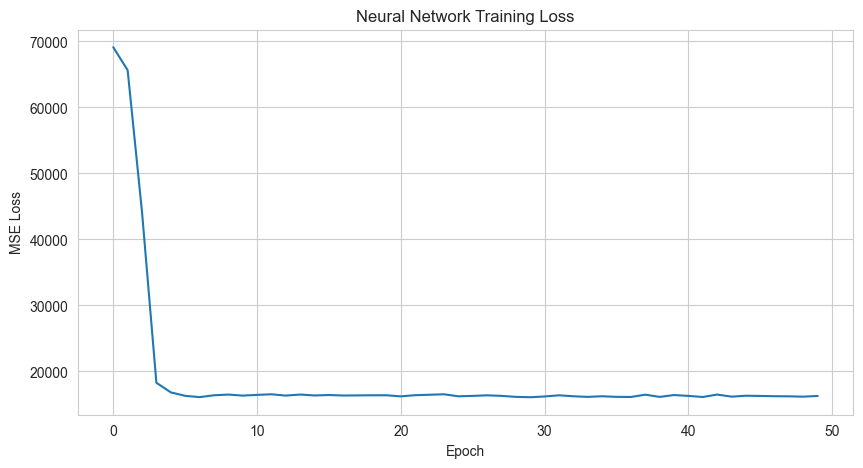

Neural Network Metrics:
         Model          Target        MAE       RMSE        R²
Neural Network     energy_kcal 134.134236 157.242125 -0.048135
Neural Network       protein_g   7.982470   9.193330 -0.018241
Neural Network carbohydrates_g  19.794916  22.780814 -0.073240
Neural Network     fat_total_g   9.874106  11.343650 -0.004375
Neural Network        sugars_g  14.035596  15.658936 -0.027976
Neural Network         fiber_g   3.590541   4.194553 -0.025141
Neural Network       sodium_mg 245.047487 287.767666 -0.047116


In [16]:
if PYTORCH_AVAILABLE:
    # Define Neural Network Model
    class NutritionMLP(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NutritionMLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, 256)
            self.dropout1 = nn.Dropout(0.3)
            self.fc2 = nn.Linear(256, 128)
            self.dropout2 = nn.Dropout(0.3)
            self.fc3 = nn.Linear(128, 64)
            self.fc4 = nn.Linear(64, output_dim)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout1(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout2(x)
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
            return x
    
    # Convert data to PyTorch tensors
    X_train_dense = X_train_tfidf.toarray().astype(np.float32)
    X_test_dense = X_test_tfidf.toarray().astype(np.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)
    
    # Initialize model
    input_dim = X_train_tfidf.shape[1]
    output_dim = y_train.shape[1]
    nn_model = NutritionMLP(input_dim, output_dim)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 50
    batch_size = 32
    train_losses = []
    
    print("Training Neural Network...")
    for epoch in range(num_epochs):
        nn_model.train()
        epoch_loss = 0
        num_batches = 0
        
        # Mini-batch training
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            # Forward pass
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    print("✓ Neural Network trained\n")
    
    # Evaluate Neural Network
    nn_model.eval()
    with torch.no_grad():
        y_pred_nn = nn_model(X_test_tensor).numpy()
    
    nn_metrics = []
    for i, target in enumerate(TARGET_NAMES):
        mae = mean_absolute_error(y_test[:, i], y_pred_nn[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred_nn[:, i]))
        r2 = r2_score(y_test[:, i], y_pred_nn[:, i])
        
        nn_metrics.append({
            'Model': 'Neural Network',
            'Target': target,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        })
    
    nn_metrics_df = pd.DataFrame(nn_metrics)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Neural Network Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()
    
    print("Neural Network Metrics:")
    print(nn_metrics_df.to_string(index=False))
    
    # Add to comparison
    all_metrics = pd.concat([all_metrics, nn_metrics_df])
else:
    print("PyTorch not available - skipping neural network training")

## 8. Model Evaluation & Comparison

Let's visualize the performance of all models across different nutrients to identify the best performer.

FINAL MODEL COMPARISON
            Model          Target        MAE       RMSE        R²
Linear Regression     energy_kcal 130.635939 153.254521  0.004351
Linear Regression       protein_g   8.098510   9.296493 -0.041221
Linear Regression carbohydrates_g  19.652158  22.633940 -0.059446
Linear Regression     fat_total_g  10.082654  11.650366 -0.059423
Linear Regression        sugars_g  13.926442  15.847292 -0.052855
Linear Regression         fiber_g   3.640334   4.236240 -0.045619
Linear Regression       sodium_mg 247.308842 290.696275 -0.068538
 Ridge Regression     energy_kcal 130.657365 153.185149  0.005253
 Ridge Regression       protein_g   8.004427   9.185205 -0.016442
 Ridge Regression carbohydrates_g  19.626365  22.575462 -0.053979
 Ridge Regression     fat_total_g  10.038785  11.579921 -0.046650
 Ridge Regression        sugars_g  13.961828  15.834167 -0.051112
 Ridge Regression         fiber_g   3.634314   4.226250 -0.040693
 Ridge Regression       sodium_mg 246.572186 290.0059

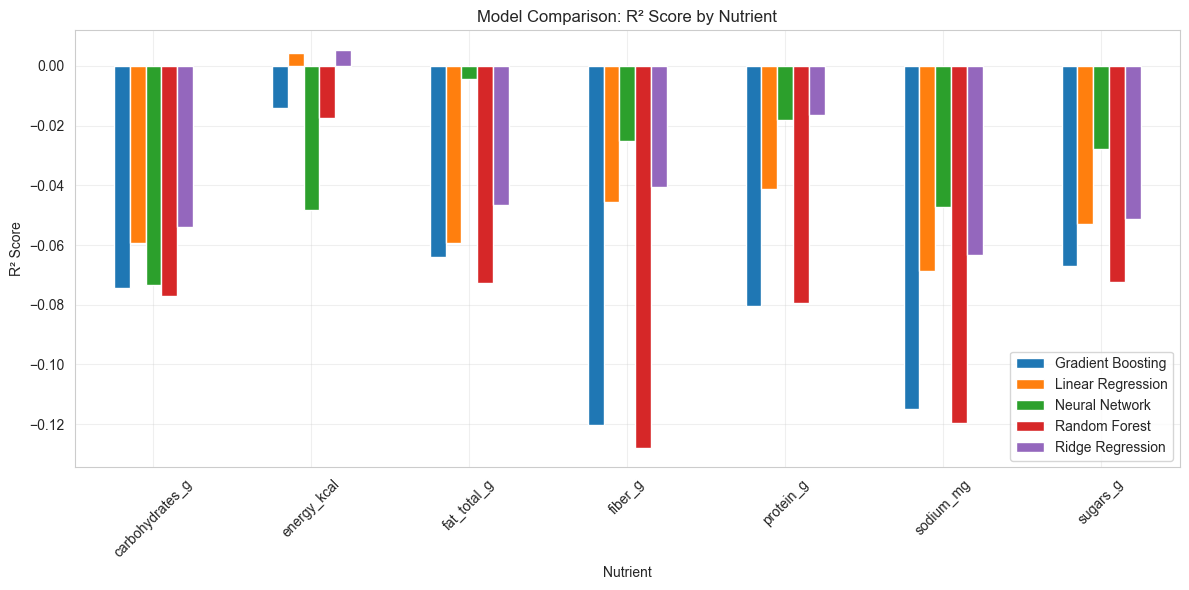

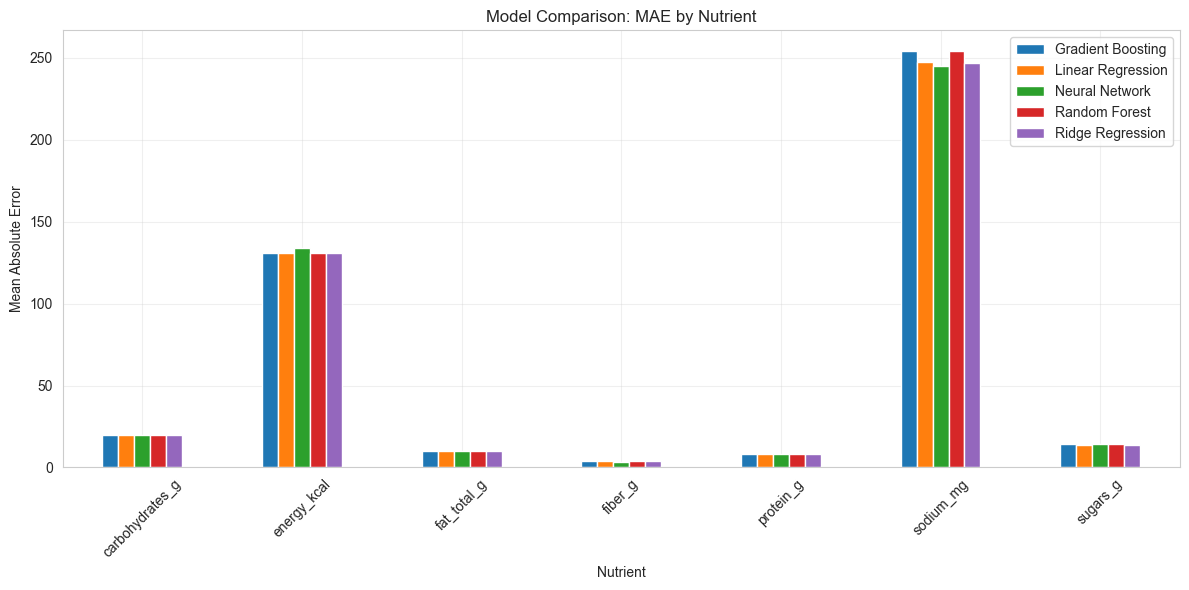


BEST MODEL PER NUTRIENT (by R²)
         Target             Model        R²        MAE
carbohydrates_g Linear Regression -0.059446  19.652158
carbohydrates_g  Ridge Regression -0.053979  19.626365
carbohydrates_g     Random Forest -0.077111  19.832933
carbohydrates_g Gradient Boosting -0.074491  19.789968
carbohydrates_g    Neural Network -0.073240  19.794916
    energy_kcal Linear Regression  0.004351 130.635939
    energy_kcal  Ridge Regression  0.005253 130.657365
    energy_kcal     Random Forest -0.017504 130.611886
    energy_kcal Gradient Boosting -0.013970 130.910186
    energy_kcal    Neural Network -0.048135 134.134236
    fat_total_g Linear Regression -0.059423  10.082654
    fat_total_g  Ridge Regression -0.046650  10.038785
    fat_total_g     Random Forest -0.072581  10.070627
    fat_total_g Gradient Boosting -0.064012  10.051261
    fat_total_g    Neural Network -0.004375   9.874106
        fiber_g Linear Regression -0.045619   3.640334
        fiber_g  Ridge Regressio

In [17]:
# Visualize R² scores by model and nutrient
print("="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(all_metrics.to_string(index=False))
print("\n")

# Plot R² comparison
pivot_r2 = all_metrics.pivot(index='Target', columns='Model', values='R²')
pivot_r2.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Model Comparison: R² Score by Nutrient')
plt.ylabel('R² Score')
plt.xlabel('Nutrient')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Plot MAE comparison
pivot_mae = all_metrics.pivot(index='Target', columns='Model', values='MAE')
pivot_mae.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Model Comparison: MAE by Nutrient')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Nutrient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Identify best model per nutrient based on R²
best_models = all_metrics.loc[all_metrics.groupby('Target')['R²'].idxmax()]
print("\n" + "="*80)
print("BEST MODEL PER NUTRIENT (by R²)")
print("="*80)
print(best_models[['Target', 'Model', 'R²', 'MAE']].to_string(index=False))

## 9. Cross-Validation Analysis

Perform k-fold cross-validation on the best performing model to ensure robust performance estimation.

In [18]:
# Assuming Gradient Boosting is typically the best - adjust if needed
print("Performing 5-Fold Cross-Validation on Gradient Boosting Model...")

# Use full dataset
X_full_tfidf = vectorizer.fit_transform(df_clean['text_features'])
y_full = df_clean[TARGET_NAMES].values

# Define cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {target: {'MAE': [], 'RMSE': [], 'R²': []} for target in TARGET_NAMES}

fold = 1
for train_idx, val_idx in kfold.split(X_full_tfidf):
    print(f"Fold {fold}/5...")
    
    X_train_cv, X_val_cv = X_full_tfidf[train_idx], X_full_tfidf[val_idx]
    y_train_cv, y_val_cv = y_full[train_idx], y_full[val_idx]
    
    # Train model
    cv_model = MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42
        )
    )
    cv_model.fit(X_train_cv, y_train_cv)
    
    # Predict and evaluate
    y_pred_cv = cv_model.predict(X_val_cv)
    
    for i, target in enumerate(TARGET_NAMES):
        mae = mean_absolute_error(y_val_cv[:, i], y_pred_cv[:, i])
        rmse = np.sqrt(mean_squared_error(y_val_cv[:, i], y_pred_cv[:, i]))
        r2 = r2_score(y_val_cv[:, i], y_pred_cv[:, i])
        
        cv_results[target]['MAE'].append(mae)
        cv_results[target]['RMSE'].append(rmse)
        cv_results[target]['R²'].append(r2)
    
    fold += 1

# Calculate mean and std for each metric
cv_summary = []
for target in TARGET_NAMES:
    cv_summary.append({
        'Target': target,
        'MAE (mean±std)': f"{np.mean(cv_results[target]['MAE']):.2f} ± {np.std(cv_results[target]['MAE']):.2f}",
        'RMSE (mean±std)': f"{np.mean(cv_results[target]['RMSE']):.2f} ± {np.std(cv_results[target]['RMSE']):.2f}",
        'R² (mean±std)': f"{np.mean(cv_results[target]['R²']):.3f} ± {np.std(cv_results[target]['R²']):.3f}"
    })

cv_summary_df = pd.DataFrame(cv_summary)
print("\n" + "="*80)
print("5-FOLD CROSS-VALIDATION RESULTS (Gradient Boosting)")
print("="*80)
print(cv_summary_df.to_string(index=False))

Performing 5-Fold Cross-Validation on Gradient Boosting Model...
Fold 1/5...
Fold 2/5...
Fold 2/5...
Fold 3/5...
Fold 3/5...
Fold 4/5...
Fold 4/5...
Fold 5/5...
Fold 5/5...

5-FOLD CROSS-VALIDATION RESULTS (Gradient Boosting)
         Target MAE (mean±std) RMSE (mean±std)  R² (mean±std)
    energy_kcal  141.10 ± 5.71   163.44 ± 4.80 -0.084 ± 0.039
      protein_g    7.72 ± 0.29     9.01 ± 0.26 -0.125 ± 0.037
carbohydrates_g   19.39 ± 0.51    22.35 ± 0.45 -0.078 ± 0.046
    fat_total_g   10.08 ± 0.23    11.77 ± 0.16 -0.054 ± 0.024
       sugars_g   12.78 ± 0.78    14.97 ± 0.65 -0.050 ± 0.038
        fiber_g    3.80 ± 0.14     4.41 ± 0.12 -0.060 ± 0.031
      sodium_mg 261.35 ± 10.06   301.48 ± 8.93 -0.068 ± 0.025

5-FOLD CROSS-VALIDATION RESULTS (Gradient Boosting)
         Target MAE (mean±std) RMSE (mean±std)  R² (mean±std)
    energy_kcal  141.10 ± 5.71   163.44 ± 4.80 -0.084 ± 0.039
      protein_g    7.72 ± 0.29     9.01 ± 0.26 -0.125 ± 0.037
carbohydrates_g   19.39 ± 0.51    22.35

## 10. Mobile App Integration Notes

**How to deploy this model in a React Native nutrition tracking app:**

1. **Export the trained model** (see next section for code):
   - Save best model with `joblib.dump(model, 'nutrition_model.pkl')`
   - Save TF-IDF vectorizer with `joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')`

2. **Backend API (Flask/FastAPI)**:
   ```python
   from flask import Flask, request, jsonify
   import joblib
   
   app = Flask(__name__)
   model = joblib.load('nutrition_model.pkl')
   vectorizer = joblib.load('tfidf_vectorizer.pkl')
   
   @app.route('/predict', methods=['POST'])
   def predict():
       data = request.json
       description = data['description']
       
       # Transform text
       X = vectorizer.transform([description])
       
       # Predict nutrients
       prediction = model.predict(X)[0]
       
       return jsonify({
           'energy_kcal': float(prediction[0]),
           'protein_g': float(prediction[1]),
           'carbohydrates_g': float(prediction[2]),
           'fat_total_g': float(prediction[3])
       })
   ```

3. **React Native Integration**:
   ```typescript
   // In your services/api.ts
   export const predictNutrition = async (description: string) => {
     const response = await fetch('http://your-api.com/predict', {
       method: 'POST',
       headers: { 'Content-Type': 'application/json' },
       body: JSON.stringify({ description })
     });
     return response.json();
   };
   
   // In AddEntryScreen.tsx
   const handleSubmit = async () => {
     const nutrients = await predictNutrition(foodDescription);
     // Update context with predicted values
     addFoodEntry({ ...nutrients, name: foodName });
   };
   ```

4. **Deployment Options**:
   - **Heroku/Render**: Deploy Flask API with model files
   - **AWS Lambda**: Serverless inference (may need optimization for size limits)
   - **Docker**: Containerize backend for consistent deployment

## 11. Export Final Model

Save the best performing model and TF-IDF vectorizer for production use.

In [ ]:
# Save best model (assuming Gradient Boosting performed best)
output_dir = "../ml_models"
import os
os.makedirs(output_dir, exist_ok=True)

# Save Gradient Boosting model
model_path = os.path.join(output_dir, "dsa330_nutrition_gbm.pkl")
vectorizer_path = os.path.join(output_dir, "dsa330_tfidf_vectorizer.pkl")

joblib.dump(gbm_model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print("="*80)
print("MODEL EXPORT COMPLETE")
print("="*80)
print(f"✓ Model saved to: {model_path}")
print(f"✓ Vectorizer saved to: {vectorizer_path}")
print(f"\nModel Details:")
print(f"  - Algorithm: Gradient Boosting Multi-Output Regressor")
print(f"  - Input: TF-IDF vectors (max {vectorizer.max_features} features)")
print(f"  - Output: {len(TARGET_NAMES)} nutrients - {', '.join(TARGET_NAMES)}")
print(f"  - Training samples: {len(X_text_train)}")
print(f"  - Test samples: {len(X_text_test)}")

# Test the saved model
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)
loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)

# Example prediction
test_description = "Chocolate chip cookie with milk"
test_vector = loaded_vectorizer.transform([test_description])
test_prediction = loaded_model.predict(test_vector)[0]

print(f"Test Input: '{test_description}'")
print(f"Predicted Nutrients:")
for target, value in zip(TARGET_NAMES, test_prediction):
    print(f"  - {target}: {value:.2f}")

print("\n✓ DSA330 Nutrition Text Regression - Project Complete!")

MODEL EXPORT COMPLETE
✓ Model saved to: ../ml_models\dsa330_nutrition_gbm.pkl
✓ Vectorizer saved to: ../ml_models\dsa330_tfidf_vectorizer.pkl

Model Details:
  - Algorithm: Gradient Boosting Multi-Output Regressor
  - Input: TF-IDF vectors (max 10000 features)
  - Output: 7 nutrients - energy_kcal, protein_g, carbohydrates_g, fat_total_g, sugars_g, fiber_g, sodium_mg


NameError: name 'X_train' is not defined